#Crude Brent Oil Prices Forecasting - Part 1: Data Collection and Processing

## Importing Necessary Packages


In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np


## Reads specific columns (close prices) from multiple sheets of an Excel file and merges them into a single DataFrame on the 'Date' column. Each sheet represnts timeseries for a stock or index (USD Dollar, Gold, Natural Gas ... etc)

In [71]:

# Define the columns you want to read from each sheet
brent_columns = ['Date', 'Close']
usd_columns = ['Date', 'Close']
sa_energ_columns = ['Date', 'Close']
sentiment_columns = ['Date', 'Csum_CrudeBERT_Plus_GT']
gold_future_columns = ['Date', 'Close']
natural_gas_columns = ['Date', 'Close']

# Load the data from the Excel file sheets, specifying only the required columns
DATAPATH_Features = 'Features.xlsx'
brent = pd.read_excel(open(DATAPATH_Features, 'rb'), sheet_name='Brent', engine='openpyxl', usecols=brent_columns, parse_dates=True)
usd = pd.read_excel(open(DATAPATH_Features, 'rb'), sheet_name='USD', engine='openpyxl', usecols=usd_columns, parse_dates=True)
TENT = pd.read_excel(open(DATAPATH_Features, 'rb'), sheet_name='SAUDI_ENERG', engine='openpyxl', usecols=sa_energ_columns, parse_dates=True)
SENTI = pd.read_excel(open(DATAPATH_Features, 'rb'), sheet_name='Sentiment', engine='openpyxl', usecols=sentiment_columns, parse_dates=True)
gold = pd.read_excel(open(DATAPATH_Features, 'rb'), sheet_name='GOLD_Future', engine='openpyxl', usecols=gold_future_columns, parse_dates=True)
gas = pd.read_excel(open(DATAPATH_Features, 'rb'), sheet_name='Natural Gas Future', engine='openpyxl', usecols=natural_gas_columns, parse_dates=True)

# load all the dataset in one data frame
merged_data = brent.merge(usd, on='Date', how='left', suffixes=('', '_usd'))
merged_data = merged_data.merge(TENT, on='Date', how='left', suffixes=('', '_tent'))
merged_data = merged_data.merge(SENTI, on='Date', how='left', suffixes=('', '_senti'))
merged_data = merged_data.merge(gold, on='Date', how='left', suffixes=('', '_gold'))
merged_data = merged_data.merge(gas, on='Date', how='left', suffixes=('', '_gas'))

print(merged_data.head(3))

        Date  Close  Close_usd  Close_tent  Csum_CrudeBERT_Plus_GT  \
0 2005-01-04  41.04      82.57         NaN                     NaN   
1 2005-01-05  40.51      82.54         NaN                     NaN   
2 2005-01-06  42.85      83.15         NaN                     NaN   

   Close_gold  Close_gas  
0       429.2      5.902  
1       427.3      5.833  
2       421.6      6.049  


In [66]:
# Display a concise summary of the merged dataframe, including the number of non-null entries and data types for each column.
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4715 entries, 0 to 4714
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    4715 non-null   datetime64[ns]
 1   Close                   4715 non-null   float64       
 2   Close_usd               4691 non-null   float64       
 3   Close_tent              2947 non-null   float64       
 4   Csum_CrudeBERT_Plus_GT  2384 non-null   float64       
 5   Close_gold              4698 non-null   float64       
 6   Close_gas               4663 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 258.0 KB


### verify that data has not been changed with the merge operation

In [73]:
# make sure the orginal dates in dataframe have not been chnaged by compare
#the date column on data to merged_data
# I did it only for brent as example

merged_dates__ = pd.DataFrame(merged_data.index.values)
print(merged_dates__.tail())
orginal_dates= pd.DataFrame(brent.index.values)
print(orginal_dates.tail())

res1= merged_dates__[0].equals(orginal_dates[0])
print(res1)



         0
4710  4710
4711  4711
4712  4712
4713  4713
4714  4714
         0
4710  4710
4711  4711
4712  4712
4713  4713
4714  4714
True


### We will extract  a specific duration (from 2012-01-0 to 2021-04-01)


In [74]:

print(SENTI.head(1))
print(SENTI.tail(1))

# as I have only sentimental score for specific duration (2012-01-0 to 2021-04-01), I need to filter the dataset based on this duration


# Define the date range
start_date = '2012-01-01'
end_date = '2021-04-01'

# Convert the Date column to datetime if it is not already
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Filter the dataframe based on the date range
filtered_data = merged_data[(merged_data['Date'] >= start_date) & (merged_data['Date'] <= end_date)]

# Verify the filtering
print(filtered_data.head(1))
print(filtered_data.tail(1))

# Optional: Display a summary to verify the filtering
print(filtered_data.info())

        Date  Csum_CrudeBERT_Plus_GT
0 2012-01-01                2.413095
           Date  Csum_CrudeBERT_Plus_GT
3378 2021-04-01            -7288.124587
           Date   Close  Close_usd  Close_tent  Csum_CrudeBERT_Plus_GT  \
1801 2012-01-03  112.13      79.61     6228.69              -34.296692   

      Close_gold  Close_gas  
1801      1600.5      2.993  
           Date  Close  Close_usd  Close_tent  Csum_CrudeBERT_Plus_GT  \
4186 2021-04-01  64.86      92.93     5523.82            -7288.124587   

      Close_gold  Close_gas  
4186      1728.4      2.639  
<class 'pandas.core.frame.DataFrame'>
Index: 2386 entries, 1801 to 4186
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    2386 non-null   datetime64[ns]
 1   Close                   2386 non-null   float64       
 2   Close_usd               2386 non-null   float64       
 3   Close_tent           

In [75]:
# Let's drop the first 6 rows
filtered_data = filtered_data[6:]
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2380 entries, 1807 to 4186
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    2380 non-null   datetime64[ns]
 1   Close                   2380 non-null   float64       
 2   Close_usd               2380 non-null   float64       
 3   Close_tent              1779 non-null   float64       
 4   Csum_CrudeBERT_Plus_GT  2378 non-null   float64       
 5   Close_gold              2380 non-null   float64       
 6   Close_gas               2372 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 148.8 KB


### Check and fill missing values

In [76]:
# check null values
print(filtered_data.isna().sum())

Date                        0
Close                       0
Close_usd                   0
Close_tent                601
Csum_CrudeBERT_Plus_GT      2
Close_gold                  0
Close_gas                   8
dtype: int64


## Fill Missing Values



In [77]:
# Fill NaN values with linear interpolation
filtered_data.interpolate(method='linear', inplace=True)


# Forward fill to handle leading NaNs
filtered_data.ffill(inplace=True)

# Backward fill to handle trailing NaNs
filtered_data.bfill(inplace=True)

# Verify that NaN values are filled
print(filtered_data.isna().sum())  # This will print the count of NaN values in each column, which should be 0 if all NaNs were filled correctly.


Date                      0
Close                     0
Close_usd                 0
Close_tent                0
Csum_CrudeBERT_Plus_GT    0
Close_gold                0
Close_gas                 0
dtype: int64


### Crude Oil Price and Volume from 2005 - April 3023

In [85]:
filtered_data.head(3)

,Date,Close,Close_usd,Close_tent,Csum_CrudeBERT_Plus_GT,Close_gold,Close_gas
1807,2012-01-11,112.24,81.35,6155.590000,-32.191320,1639.6,2.774
1808,2012-01-12,111.26,80.77,6148.413333,-149.519954,1647.7,2.697
1809,2012-01-13,110.44,81.52,6141.236667,-198.907999,1630.8,2.670


In [95]:
#save your work
filtered_data.to_csv("data.csv", encoding='utf-8', index=False)


# Data Analysis and Exploration

In [80]:
# Import the final prepared dataset

df= pd.read_csv('data.csv')


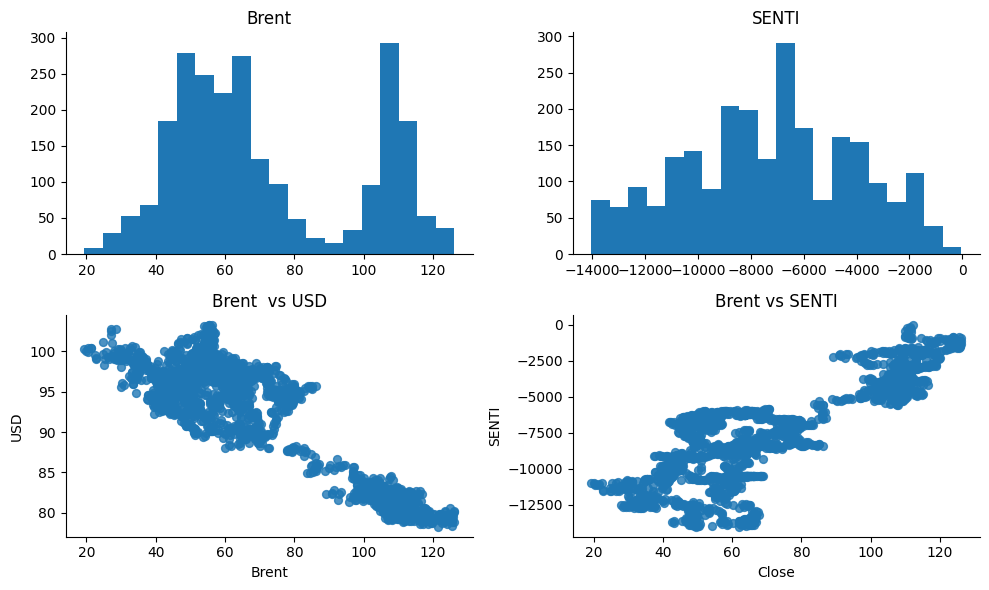

In [96]:
# some plots


# Create a figure with subplots arranged in 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# Plot the first histogram
axs[0, 0].hist(df['Close'], bins=20)
axs[0, 0].set_title('Brent')
axs[0, 0].spines['top'].set_visible(False)
axs[0, 0].spines['right'].set_visible(False)


# Plot the second  histogram
axs[0, 1].hist(df['Csum_CrudeBERT_Plus_GT'], bins=20)
axs[0, 1].set_title('SENTI')
axs[0, 1].spines['top'].set_visible(False)
axs[0, 1].spines['right'].set_visible(False)

# Plot the first scatter plot
axs[1, 0].scatter(df['Close'], df['Close_usd'], s=32, alpha=0.8)
axs[1, 0].set_title('Brent  vs USD')
axs[1, 0].set_xlabel('Brent')
axs[1, 0].set_ylabel('USD')
axs[1, 0].spines['top'].set_visible(False)
axs[1, 0].spines['right'].set_visible(False)

# Plot the second scatter plot
axs[1, 1].scatter(df['Close'], df['Csum_CrudeBERT_Plus_GT'], s=32, alpha=0.8)
axs[1, 1].set_title('Brent vs SENTI')
axs[1, 1].set_xlabel('Close')
axs[1, 1].set_ylabel('SENTI')
axs[1, 1].spines['top'].set_visible(False)
axs[1, 1].spines['right'].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [97]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2380 entries, 0 to 2379
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    2380 non-null   object 
 1   Close                   2380 non-null   float64
 2   Close_usd               2380 non-null   float64
 3   Close_tent              2380 non-null   float64
 4   Csum_CrudeBERT_Plus_GT  2380 non-null   float64
 5   Close_gold              2380 non-null   float64
 6   Close_gas               2380 non-null   float64
dtypes: float64(6), object(1)
memory usage: 130.3+ KB


In [99]:

#Scaling the data
from sklearn import preprocessing

# Separate the 'Date' column from the rest of the data
date_column = df[['Date']]
data_columns = df.drop('Date', axis=1)

# Initialize the MinMaxScaler
scaler = preprocessing.MinMaxScaler()

# Fit and transform the data columns
scaled_data = scaler.fit_transform(data_columns)

# Convert the scaled data back to a dataframe
scaled_df = pd.DataFrame(scaled_data, columns=data_columns.columns)

# Concatenate the 'Date' column back to the scaled dataframe
scaled_df = pd.concat([date_column.reset_index(drop=True), scaled_df], axis=1)

# Display the scaled dataframe
print(scaled_df.head())

         Date     Close  Close_usd  Close_tent  Csum_CrudeBERT_Plus_GT  \
0  2012-01-11  0.869211   0.123299    0.476311                1.000000   
1  2012-01-12  0.860043   0.100080    0.475043                0.991620   
2  2012-01-13  0.852372   0.130104    0.473775                0.988093   
3  2012-01-16  0.859482   0.130104    0.472508                0.979677   
4  2012-01-17  0.862569   0.116493    0.454583                0.980018   

   Close_gold  Close_gas  
0    0.578545   0.276837  
1    0.586488   0.260339  
2    0.569916   0.254553  
3    0.594234   0.235055  
4    0.595509   0.215556  


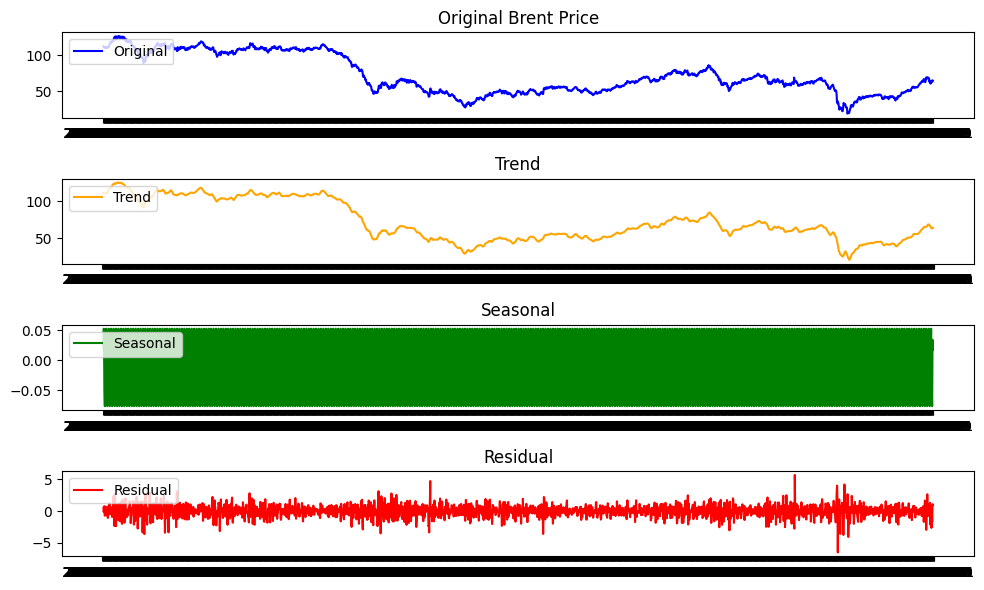

In [104]:
#To decompose the Brent price components into trend, seasonality,
#and residuals, you can use the seasonal_decompose function from the statsmodels library.

from statsmodels.tsa.seasonal import seasonal_decompose

brent = df [['Date', 'Close']]
brent.set_index('Date', inplace=True)

# Decompose the Brent price data
decomposition = seasonal_decompose(brent['Close'], model='additive', period=7)

# Extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
plt.figure(figsize=(10, 6))

plt.subplot(411)
plt.plot(brent['Close'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.title('Original Brent Price')

plt.subplot(412)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.title('Trend')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal')

plt.subplot(414)
plt.plot(residual, label='Residual', color='red')
plt.legend(loc='upper left')
plt.title('Residual')

plt.tight_layout()
plt.show()

In [114]:
df.head(3)

,Date,Close,Close_usd,Close_tent,Csum_CrudeBERT_Plus_GT,Close_gold,Close_gas,SENT1
0,2012-01-11,112.24,81.35,6155.590000,-32.191320,1639.6,2.774,1.000000
1,2012-01-12,111.26,80.77,6148.413333,-149.519954,1647.7,2.697,0.991620
2,2012-01-13,110.44,81.52,6141.236667,-198.907999,1630.8,2.670,0.988093


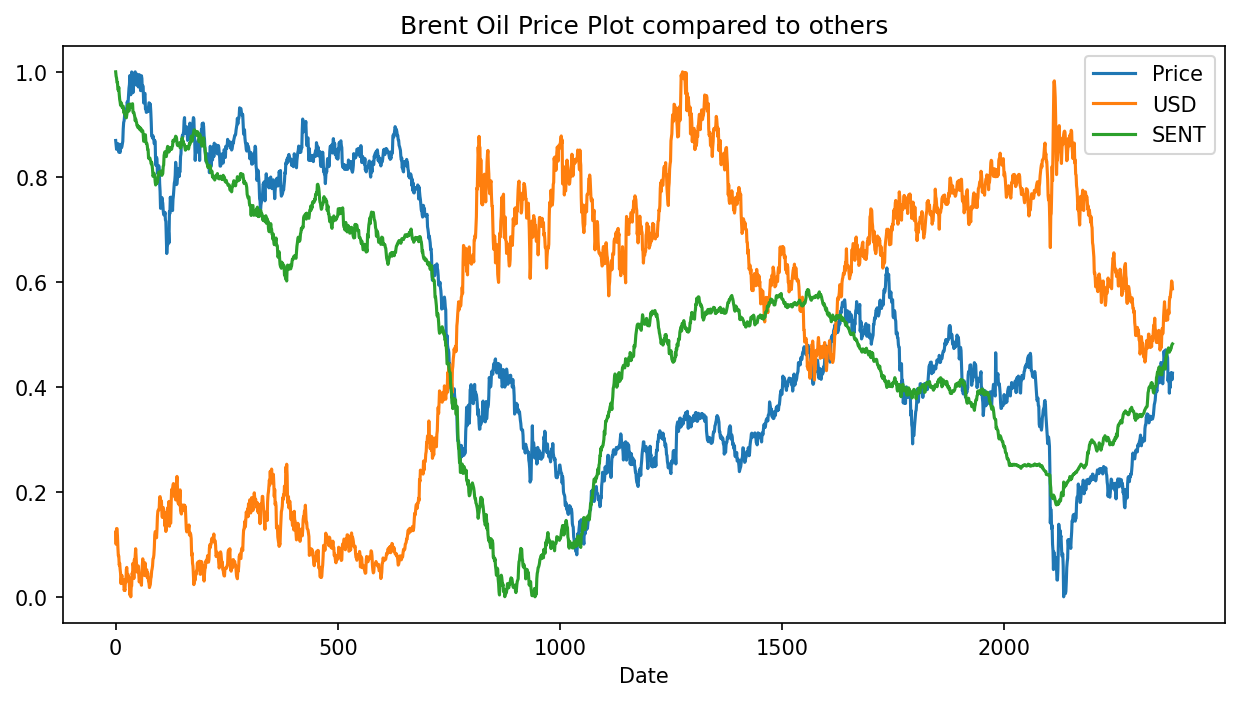

In [117]:
# Visualizing The Price and Volume


plt.figure(figsize=(10, 5), dpi=150)

scaled_df['Close'].plot(label='Price')
scaled_df['Close_usd'].plot(label='USD')
scaled_df['Csum_CrudeBERT_Plus_GT'].plot(label='SENT')

# adding title
plt.title('Brent Oil Price Plot compared to others')

#plt.ylabel('Prices & Volume')
plt.xlabel('Date')
plt.legend()

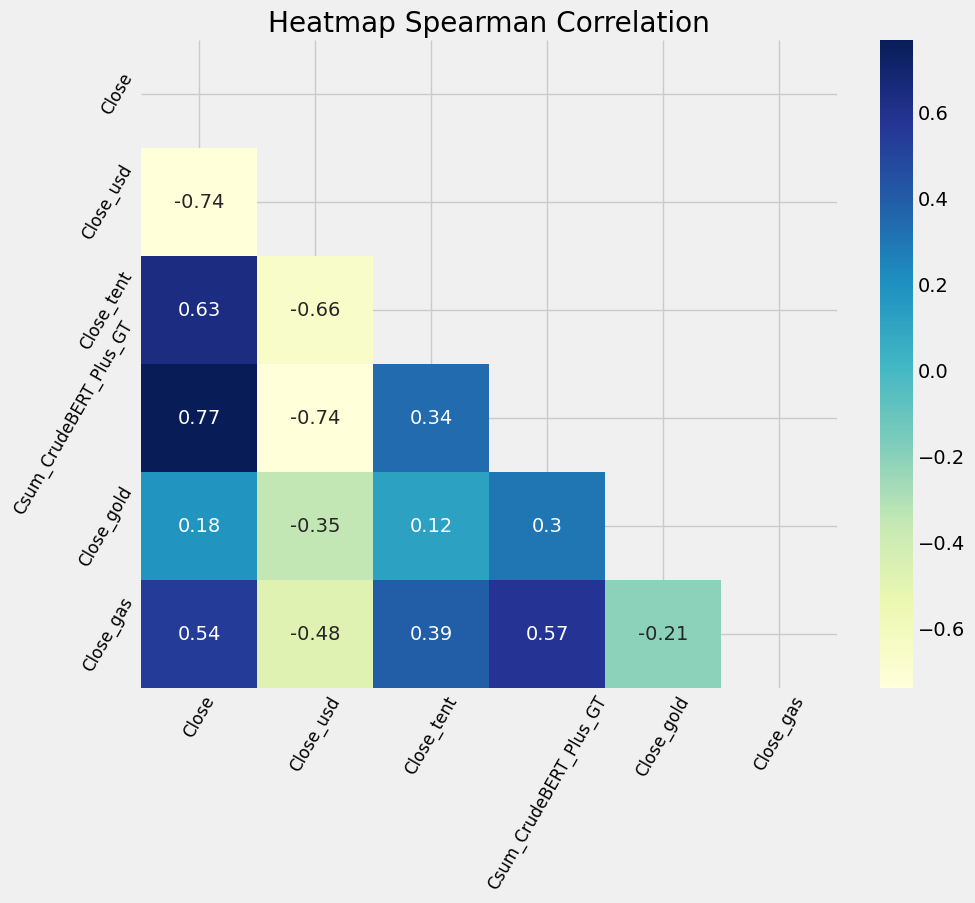

In [123]:
# Heatmap Spearman Correlation for the data 2007-2023 without Sentiment variable

df_scaled_no_dat = scaled_df.drop('Date', axis=1)

plt.figure(figsize=(10,8))
matrix = np.triu(df_scaled_no_dat.corr(method='spearman'))
heat_map = sns.heatmap(df_scaled_no_dat.corr(method='spearman'),annot=True,annot_kws={"size":14},cmap= 'YlGnBu',mask=matrix)
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=60)
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=60)
plt.tick_params(labelsize=12)
plt.title('Heatmap Spearman Correlation')
plt.style.use('fivethirtyeight')

In [124]:
df_scaled_no_dat.corr(method='spearman')

,Close,Close_usd,Close_tent,Csum_CrudeBERT_Plus_GT,Close_gold,Close_gas
Close,1.000000,-0.739532,0.632651,0.767166,0.181335,0.540040
Close_usd,-0.739532,1.000000,-0.660820,-0.735409,-0.349891,-0.479352
Close_tent,0.632651,-0.660820,1.000000,0.340652,0.121391,0.385374
Csum_CrudeBERT_Plus_GT,0.767166,-0.735409,0.340652,1.000000,0.299859,0.573248
Close_gold,0.181335,-0.349891,0.121391,0.299859,1.000000,-0.206814
Close_gas,0.540040,-0.479352,0.385374,0.573248,-0.206814,1.000000
